In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm
import os
import seaborn as sns
import random
import math
import scipy as sp
import itertools
sns.set(style="whitegrid")

Load and check data:

In [2]:
alldata = pd.read_csv("error_data.csv")

In [3]:
alldata.head()

,participant,phase,condition,cue,target,response,rt,correct,Column1,Column2
0,1001.0,learn,1.0,EMPIRE,STATE,KING,3457.0,2.0,NaN,NaN
1,1001.0,learn,1.0,CHUNK,BLOCK,HUNK,3361.0,2.0,NaN,NaN
2,1001.0,learn,1.0,GLIDE,HANG,FLY,2177.0,2.0,NaN,NaN
3,1001.0,learn,1.0,SAIL,OCEAN,BOAT,2341.0,2.0,NaN,NaN
4,1001.0,learn,1.0,ELEVATOR,BUILDING,UP,3464.0,2.0,NaN,NaN


In [4]:
alldata.shape

(5670, 10)

# Log likelihood

Implement ACT-R code:

In [5]:
def activation(traces, time, decay):
    """Computes the activation of a memory given its history of retrievals"""
    ftraces = [x for x in traces if x < time]
    decay = max(0, decay)  # Allows no positive decay rates in equation 
    decay - min(decay, 5)
    times = time - np.array(ftraces)
    odds = times ** -decay
    return np.log(np.sum(odds))

activation([5, 10, 15], 40, 0.5)

-0.5949230018850301

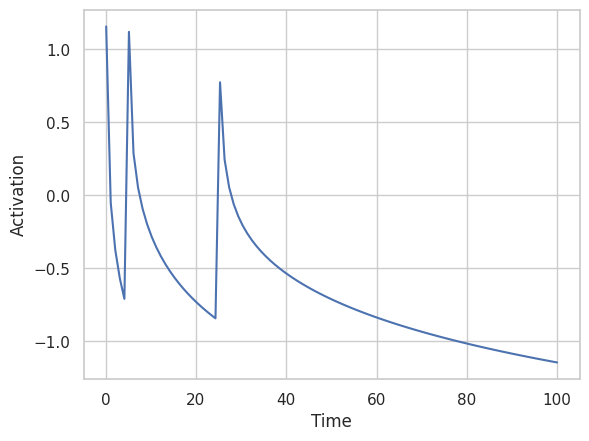

In [6]:
time = np.linspace(0.1, 100, 100)
traces = [0.001, 5, 25]
y = []
for t in time:
    act = activation(traces, t, 0.5)
    y += [act]
    
plt.plot(time, y)
plt.xlabel("Time")
plt.ylabel("Activation")
plt.show()

Create loglikelihood function for the model

In [7]:
def boltzmann(options, values, temperature):
    """Returns a Boltzmann distribution of the probabilities of each option"""
    temperature = max(temperature, 0.01) 
    vals = np.array(values)/temperature
    #bvals = np.exp(vals)/np.sum(np.exp(vals))
    bvals = np.exp(vals - np.max(vals)) / np.exp(vals - np.max(vals)).sum()
    return dict(zip(options, bvals))

In [8]:
boltzmann([2,3], [1, 0.7], 1)

{2: 0.574442516811659, 3: 0.425557483188341}

Create a loglikelihood function for the elaborative model, each error item is given additional spreading activation given the max association (mas) parameter

### Complete *elaborative* model

In [ ]:
def LLelab(data, decay, temp, mas):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    # since we don't have data for when study items were presented in each participant's learning phase
    # we will use the presentation of the error items and interleaven the study items in between
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 0
    step = 10 #time for learning each item
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase


    # model testing phase
    LL = 0
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
      # Calculate log likelihood of response- possible options are 19 random integers
      # or correct associate
      options = DM[cue].keys()
      # create spreading activation additional error component given size of cue's dec mem
      cueMem = len(DM[cue])
      add = (mas - np.log((cueMem + 1)/2)) - (mas - np.log((cueMem + 1)/1))
      # if error condition, add spreading activation
      values = [activation(DM[cue][opt], time, decay) if condition == 1 else 
       (activation(DM[cue][opt], time, decay) + add) for opt in options]
      prob = boltzmann(options, values, temp)[response]
    
      # Sum up the LLs
      LL += np.log(max(prob, 10e-10))

       # add time taken to responde
      time += rt/1000
    
    return LL

In [ ]:
LLelab(alldata[alldata.participant == 1001], 0.5, 1, 1.6)

-174.4412782790136

In [ ]:
LLelab(alldata[alldata.participant == 1002], 0.5, 1, 4)

-177.46115123650327

Create a loglikelihood function of the mediator model, where there are two routes to make a decision: To remember something that worked and to remember something that did not.

In [ ]:
def LLmed(data, decay, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 0
    step = 10 #time for learning each item
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase

    # model testing phase
    LL = 0
    
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
        # Calculate log likelihood of response- possible options are 19 random integers
        # or correct associate
        options = DM[cue].keys()
        # create spreading activation additional error component given size of cue's dec mem
        cueMem = len(DM[cue])
        # if error condition, add spreading activation
        values = [activation(DM[cue][opt], time, decay) for opt in options]
        prob1 = boltzmann(options, values, temp)[response]
        
        # probability of retrieving error memory
        if condition == 1:
          error = errorResp[cue]
          prob2 = boltzmann(options, values, temp)[error]
        else:
          prob2 = 0
        
        # Sum up the LLs
        LL += np.log(max(prob1 + prob2, 10e-10))
        
         # add time taken to responde
        time += rt/1000
        
    return LL

In [ ]:
LLmed(alldata[alldata.participant == 1001], 0.5, 1)

-148.38513809212435

In [ ]:
LLmed(alldata[alldata.participant == 1002], 0.5, 1)

-150.88790456104599

# Create RT models

In [9]:
def responsetime(activation, ter, F=1, f=1):
    return ter + F * np.exp(-f * activation)

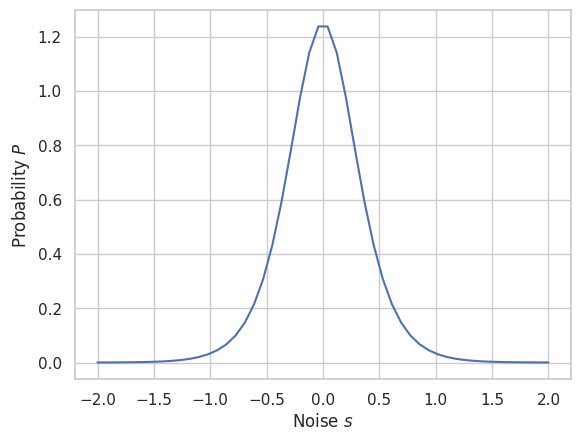

In [10]:
noise = np.linspace(-2, 2)
dist = sp.stats.logistic(0, 0.2)
plt.plot(noise, dist.pdf(noise))
plt.xlabel("Noise $s$")
plt.ylabel("Probability $P$")
plt.show()

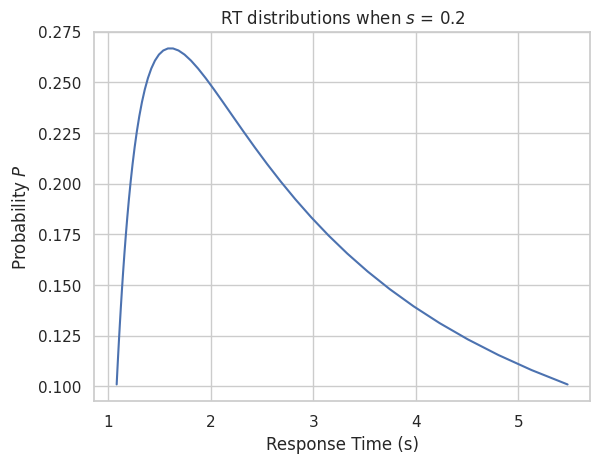

In [22]:
rts = [responsetime((0.5 - x), 1) for x in noise]
plt.plot(rts, dist.pdf(noise))
plt.xlabel("Response Time (s)")
plt.ylabel("Probability $P$")
plt.title("RT distributions when $s$ = 0.2")
plt.show()

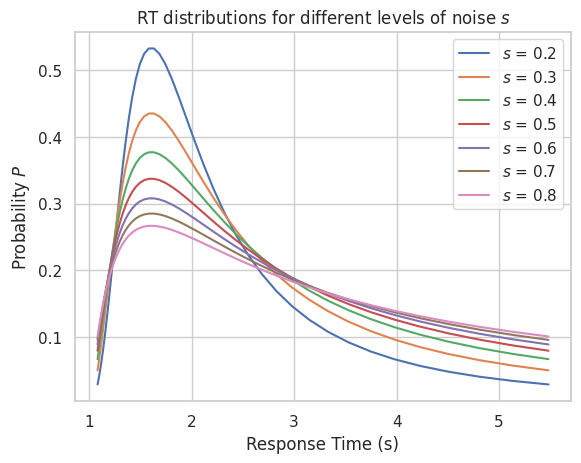

In [23]:
for s in np.linspace(0.2, 0.8, 7):
    dist = sp.stats.logistic(0, (math.sqrt((math.pi**2)*s)/3))
    rts = [responsetime((0.5 - x), 1) for x in noise]
    plt.plot(rts, dist.pdf(noise))
plt.legend(["$s$ = %.1f" % (x,) for x in np.linspace(0.2, 0.8, 7)])
plt.xlabel("Response Time (s)")
plt.ylabel("Probability $P$")
plt.title("RT distributions for different levels of noise $s$")
plt.show()

## Updated noise SD added here

In [19]:
from urllib.request import proxy_bypass
def rtProb(rt, activation, s, ter):
  """Takes one parameter for noise, s, and outputs a probability distribution for response times"""
  noise = np.linspace(-2, 2)
  dist = sp.stats.logistic(0, (math.sqrt((math.pi**2)*s)/3))
  rts = [responsetime((activation - x), ter) for x in noise]
  prob = dist.pdf(noise)
  rtprob = {rts[i]:prob[i]for i in range(len(noise))}
  val = min(rtprob.keys(), key=lambda x: abs(x - (rt/1000)))
  return rtprob[val]

In [20]:
rtProb(5030, 3, 1, 1)

0.1072925734674144

## Elaborative Model

In [13]:
def LLelabRT(data, decay, temp, ter, mas = 1.6):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 0
    step = 10 #time for learning each item
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase


    # model testing phase
    LL = 0
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
      # Calculate log likelihood of response- possible options are 19 random integers
      # or correct associate
      options = DM[cue].keys()
      # create spreading activation additional error component given size of cue's dec mem
      cueMem = len(DM[cue])
      add = (mas - np.log((cueMem + 1)/2)) - (mas - np.log((cueMem + 1)/1))
      # if error condition, add spreading activation
      values = [(activation(DM[cue][opt], time, decay) + add) if condition == 1 else 
       activation(DM[cue][opt], time, decay) for opt in options]
      prob = boltzmann(options, values, temp)[response]
    
      # now calculate response times:
      if condition == 1:
        resp_activation = activation(DM[cue][response], time, decay) + add
      else: 
        resp_activation = activation(DM[cue][response], time, decay)

      
      prob_rt = rtProb(rt, resp_activation, temp, ter)

      # Sum up the LLs
      LL += (np.log(max(prob, 10e-10)) + np.log(max(prob_rt, 10e-10)))

       # add time taken to responde
      time += rt/1000
    
    return LL

In [26]:
LLelabRT(alldata[alldata.participant == 1001], 0.5, 1, 1.6, 1)

-289.25863875844

In [24]:
LLelabRT(alldata[alldata.participant == 1002], 0.5, 1, 1.6, 1)

-301.81187261225193

## Mediator Model

## Updated noise SD *also* added here

In [31]:
from urllib.request import proxy_bypass
def rtProb2(rt, resp_activation, error_activation, condition, s, ter):
  """Takes one parameter for noise, s, and outputs a probability distribution for response times"""
  noise = np.linspace(-2, 2)
  dist = sp.stats.logistic(0, (math.sqrt((math.pi**2)*s)/3))
  if condition == 1:
    rts = [(responsetime((resp_activation - x), ter) + responsetime((error_activation - x), ter)) for x in noise]
  else: 
    rts = [responsetime((resp_activation - x), ter) for x in noise]
  prob = dist.pdf(noise)
  rtprob = {rts[i]:prob[i]for i in range(len(noise))}
  val = min(rtprob.keys(), key=lambda x: abs(x - (rt/1000)))
  return rtprob[val]

In [32]:
rtProb2(6100, 3, 2, 1, 0.2, 1)

0.029021222079091556

In [33]:
def LLmedRT(data, decay, temp, ter):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 0
    step = 10 #time for learning each item
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase

    # model testing phase
    LL = 0
    
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
        # Calculate log likelihood of response- possible options are 19 random integers
        # or correct associate
        options = DM[cue].keys()

        # calculate probability of retrieving given response
        values = [activation(DM[cue][opt], time, decay) for opt in options]
        prob1 = boltzmann(options, values, temp)[response]
        
        # probability of retrieving error memory
        if condition == 1:
          error = errorResp[cue]
          prob2 = boltzmann(options, values, temp)[error]
        else:
          prob2 = 0
        
        # add response times calculations
        # probability of given response time with
        respAct = activation(DM[cue][response], time, decay)
        if condition == 1:
          error = errorResp[cue]
          errorAct = activation(DM[cue][error], time, decay)
          prob_rt = rtProb2(rt, respAct, errorAct, condition, temp, ter)
        else:
          errorAct = 0
          prob_rt = rtProb2(rt, respAct, errorAct, condition, temp, ter)

        # Sum up the LLs
        LL += (np.log(max(prob1 + prob2, 10e-10)) + np.log(max(prob_rt, 10e-10)))
        
         # add time taken to responde
        time += rt/1000
        
    return LL

In [34]:
LLmedRT(alldata[alldata.participant == 1001], 0.5, 1, 1)

-268.5846010228856

In [35]:
LLmedRT(alldata[alldata.participant == 1002], 0.5, 1, 1)

-282.17452703368673

# Optimizing the Models

## Elaborative Optimization

In [36]:
def vLLelab(array):
    """Vector function of procedural log-likelihood"""
    global data
    decay, temp, ter = array
    return -1 * LLelabRT(data, decay, temp, ter)

## Mediator Optimization

In [37]:
def vLLmed(array):
    """Vector function of procedural log-likelihood"""
    global data
    decay, temp, ter = array
    return -1 * LLmedRT(data, decay, temp, ter)

# Calculate LL for each ppt and assign best model

## compute the best parameters and high log-liklihoods of each model for each participant

In [40]:
alldata.participant.unique()

array([1001., 1002., 1003., 1004., 1005., 1006., 1007., 1008., 1009.,
       1010., 1011., 1012., 1013., 1014., 1015., 1016., 1017., 1018.,
       1019., 1020., 1021., 1022., 1023., 1024., 1025., 1026., 1028.,
       1029., 1031., 1032., 1033., 1035., 1036., 1037., 1038., 1039.,
       1040., 1041., 1042., 1043., 1044., 1045., 1046., 1047., 1049.,
       1050., 1051., 1053., 1054., 1055., 1056., 1057., 1058., 1059.,
       1061., 1063., 1064., 1065., 1067., 1068., 1069.,   nan])

In [42]:
DO_ALL = True
dataframe = []

if DO_ALL:
    for ppt in alldata.participant.unique(): 
        data = alldata[alldata.participant == ppt]
        edecay, etemp, eter = opt.minimize(vLLelab, x0 = [0.5, 1, 1], method = "Powell", bounds=[[0.01, 2], [0, 2], [0.1, 2]]).x
        llelab = LLelabRT(data, edecay, etemp, eter)
            
        mdecay, mtemp, mter = opt.minimize(vLLmed, x0 = [0.5, 1, 1], method = "Powell", bounds=[[0.01, 2], [0, 2], [0.1, 2]]).x
        llmed = LLmedRT(data, mdecay, mtemp, mter)
            
        best = "Mediator"
        if llelab > llmed:
            best = "Elaborative"
            
        diff = llmed - llelab
            
        row = [ppt, edecay, etemp, eter, llelab, mdecay, mtemp, mter, llmed, best, diff]
            
        dataframe += [row]

    result = pd.DataFrame(dataframe, columns=["Participant", "elab.decay", "elab.temp", "elab.ter", "elab.LL", "med.decay", "med.temp", "med.ter", "med.LL", "best.model", "diff.LL"])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [43]:
if DO_ALL:
    result.to_csv("LL_model1.csv")
else:
    result = pd.read_csv("LL_model1.csv")
result

,Participant,elab.decay,elab.temp,elab.ter,elab.LL,med.decay,med.temp,med.ter,med.LL,best.model,diff.LL
0,1001.0,0.338333,0.237445,0.164591,-216.196203,2.000000,0.456043,1.999988,-259.294106,Elaborative,-43.097904
1,1002.0,1.999952,0.736813,1.999956,-301.056766,1.999985,0.548203,2.000000,-266.740114,Mediator,34.316652
2,1003.0,1.999952,0.684344,1.999956,-298.447762,2.000000,0.478494,1.999988,-259.735630,Mediator,38.712132
3,1004.0,1.999952,1.054929,1.999956,-314.803501,2.000000,0.600874,1.999988,-276.191047,Mediator,38.612455
4,1005.0,2.000000,0.463938,1.999988,-268.973207,2.000000,0.397126,1.999988,-234.606372,Mediator,34.366835
...,...,...,...,...,...,...,...,...,...,...,...
57,1065.0,1.999952,0.496218,1.999956,-281.171395,2.000000,0.431088,1.999988,-251.126376,Mediator,30.045019
58,1067.0,0.277098,0.488295,0.167128,-283.671606,1.999952,0.904589,1.999956,-293.850901,Elaborative,-10.179295
59,1068.0,0.305314,0.182183,0.145658,-154.286312,2.000000,0.365119,1.999988,-234.323971,Elaborative,-80.037658
60,1069.0,2.000000,0.444467,1.999988,-265.709057,2.000000,0.414760,1.999988,-239.144422,Mediator,26.564635


In [44]:
result.dropna()

,Participant,elab.decay,elab.temp,elab.ter,elab.LL,med.decay,med.temp,med.ter,med.LL,best.model,diff.LL
0,1001.0,0.338333,0.237445,0.164591,-216.196203,2.000000,0.456043,1.999988,-259.294106,Elaborative,-43.097904
1,1002.0,1.999952,0.736813,1.999956,-301.056766,1.999985,0.548203,2.000000,-266.740114,Mediator,34.316652
2,1003.0,1.999952,0.684344,1.999956,-298.447762,2.000000,0.478494,1.999988,-259.735630,Mediator,38.712132
3,1004.0,1.999952,1.054929,1.999956,-314.803501,2.000000,0.600874,1.999988,-276.191047,Mediator,38.612455
4,1005.0,2.000000,0.463938,1.999988,-268.973207,2.000000,0.397126,1.999988,-234.606372,Mediator,34.366835
...,...,...,...,...,...,...,...,...,...,...,...
56,1064.0,0.360474,0.169214,0.121188,-149.196001,2.000000,0.358812,1.999988,-229.683838,Elaborative,-80.487837
57,1065.0,1.999952,0.496218,1.999956,-281.171395,2.000000,0.431088,1.999988,-251.126376,Mediator,30.045019
58,1067.0,0.277098,0.488295,0.167128,-283.671606,1.999952,0.904589,1.999956,-293.850901,Elaborative,-10.179295
59,1068.0,0.305314,0.182183,0.145658,-154.286312,2.000000,0.365119,1.999988,-234.323971,Elaborative,-80.037658


In [46]:
elab_LL = result["elab.LL"].values
med_LL = result["med.LL"].values

BEST = result["best.model"].values
BEST_ = np.unique(BEST)

COLORS = ['#c9a818', '#674b94']

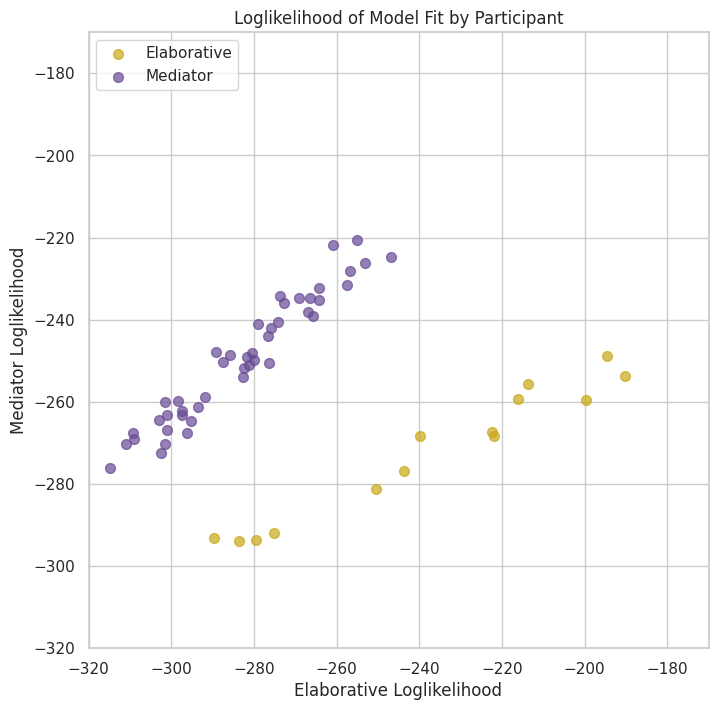

In [47]:
fig, ax = plt.subplots(figsize=(8,8))
for best, color in zip(BEST_, COLORS):
    idxs = np.where(best == BEST)
    # No legend will be generated if we don't pass label=species
    ax.scatter(
        elab_LL[idxs], med_LL[idxs], label=best,
        s=50, color=color, alpha=0.7
    )
    
_ = plt.xlabel("Elaborative Loglikelihood")
_ = plt.ylabel("Mediator Loglikelihood")
_ = plt.title("Loglikelihood of Model Fit by Participant")
_ = plt.xlim([-320, -170])
_ = plt.ylim([-320, -170])
_ = plt.show
ax.legend(loc = "upper left");

In [48]:
res = pd.read_csv("LL_model1.csv")
res

,Unnamed: 0,Participant,elab.decay,elab.temp,elab.ter,elab.LL,med.decay,med.temp,med.ter,med.LL,best.model,diff.LL
0,0,1001.0,0.338333,0.237445,0.164591,-216.196203,2.000000,0.456043,1.999988,-259.294106,Elaborative,-43.097904
1,1,1002.0,1.999952,0.736813,1.999956,-301.056766,1.999985,0.548203,2.000000,-266.740114,Mediator,34.316652
2,2,1003.0,1.999952,0.684344,1.999956,-298.447762,2.000000,0.478494,1.999988,-259.735630,Mediator,38.712132
3,3,1004.0,1.999952,1.054929,1.999956,-314.803501,2.000000,0.600874,1.999988,-276.191047,Mediator,38.612455
4,4,1005.0,2.000000,0.463938,1.999988,-268.973207,2.000000,0.397126,1.999988,-234.606372,Mediator,34.366835
...,...,...,...,...,...,...,...,...,...,...,...,...
57,57,1065.0,1.999952,0.496218,1.999956,-281.171395,2.000000,0.431088,1.999988,-251.126376,Mediator,30.045019
58,58,1067.0,0.277098,0.488295,0.167128,-283.671606,1.999952,0.904589,1.999956,-293.850901,Elaborative,-10.179295
59,59,1068.0,0.305314,0.182183,0.145658,-154.286312,2.000000,0.365119,1.999988,-234.323971,Elaborative,-80.037658
60,60,1069.0,2.000000,0.444467,1.999988,-265.709057,2.000000,0.414760,1.999988,-239.144422,Mediator,26.564635


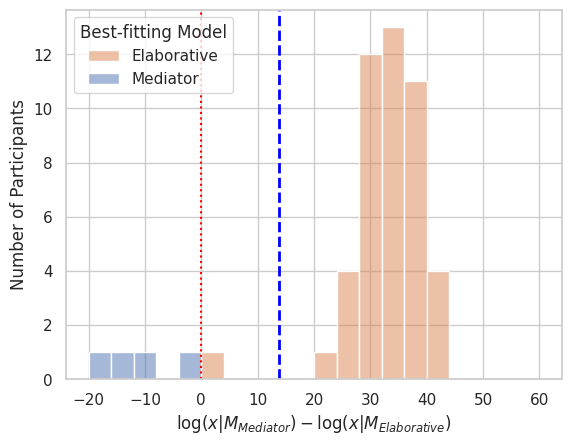

In [49]:
sns.histplot(res, x="diff.LL", hue="best.model", binwidth=4, binrange=[-20, 60], stat="count", legend="False")
plt.legend(loc="upper left", title="Best-fitting Model", labels=['Elaborative', 'Mediator'])
plt.xlabel("$\log(x|M_{Mediator}) - \log(x|M_{Elaborative})$") 
plt.ylabel("Number of Participants") 

plt.axvline(x=0, linestyle="dotted", color="red")
plt.axvline(x=np.mean(res['diff.LL']), linestyle="dashed", color="blue", linewidth=2)
plt.show()

In [50]:
totalLL = np.sum(res['diff.LL'])
print(totalLL)
print(np.mean(res['diff.LL']))

854.3069342875261
13.779144101411712
